## Time Series Forecasting with Deep Neural Network

#### Preparing features and labels

Before feeding the data into Neural Network, we have to do some modification to the data so they can be accepted by the model. We are going to use windowing technique which basically group the data into feature and label. The label will be the next value. You can take a look at the next few cells to give an idea what we are going to do

Official Documentation: [Here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Helpful Resource:  
- https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0



In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
df_0 = pd.read_csv('./data/7832_battery.csv')
df_0.head()

,v_bat,battery_soc,temperature,box_id,event_time
0,70.92,58.43,34.59,7832,2024-11-06 14:01:41
1,70.92,58.43,34.59,7832,2024-11-06 14:01:41
2,70.92,58.43,34.59,7832,2024-11-06 14:01:41
3,70.92,58.43,34.59,7832,2024-11-06 14:01:41
4,70.92,58.50,34.56,7832,2024-11-06 14:00:42


In [3]:
df_0['box_id'].unique()

array([7832])

In [4]:
def calculate_vol(v_bat):
    return (((v_bat/100) * 1200) + 3000)/1000

def calculate_soc(Vnormalized):
    return 112 - 112/(1 + ((1.9*Vnormalized)**2.9))

def calculate_soc_2(Vnormalized):
    return 270 - 270/((1 + ((3.5 * Vnormalized)**8))**0.045)

def normalize(voltage):
    return (voltage - min_vol) / (max_vol - min_vol)

max_vol = 4.2
min_vol = 3

df = (df_0
      .assign(vol=lambda x: x['v_bat'].apply(calculate_vol))
      .assign(Vnormalized=lambda x: x['vol'].apply(normalize))
      .assign(soc=lambda x: x['Vnormalized'].apply(calculate_soc))
      .assign(soc_2=lambda x: x['Vnormalized'].apply(calculate_soc_2)))
df.head()

,v_bat,battery_soc,temperature,box_id,event_time,vol,Vnormalized,soc,soc_2
0,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
1,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
2,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
3,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
4,70.92,58.50,34.56,7832,2024-11-06 14:00:42,3.85104,0.7092,78.812187,75.370364


In [5]:
df = df.set_index('event_time')
df.head()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:00:42,70.92,58.50,34.56,7832,3.85104,0.7092,78.812187,75.370364


In [6]:
df = df[['box_id', 'temperature', 'vol', 'battery_soc', 'soc', 'soc_2']]

In [7]:
df.index = pd.to_datetime(df.index)
# df.sort_values('event_time', ascending=True)
df.sort_index(inplace=True)
df.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-02 13:34:10,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:20,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:23,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:23,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:23,7832,31.28,3.96,64.33,86.357805,83.627556


In [8]:
va = df.resample('T').mean()
va.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-02 13:34:00,7832.0,31.280000,3.96000,64.330000,86.357805,83.627556
2024-11-02 13:35:00,7832.0,31.504444,3.84304,48.088889,76.902486,73.881657
2024-11-02 13:36:00,7832.0,34.880000,3.98004,72.810000,87.523125,85.008249
2024-11-02 13:37:00,7832.0,35.980000,3.99000,72.940000,88.079383,85.680280
2024-11-02 13:38:00,7832.0,37.030000,3.99696,73.150000,88.459348,86.144465


In [9]:
va = va.ffill()
# df_ip = df.resample('T').mean().interpolate(method='linear')

In [10]:
split_date = '2024-11-06'
vol_train = va.loc[va.index <= split_date].copy()
vol_test = va.loc[va.index > split_date].copy()

In [11]:
print('Train:\t', len(vol_train))
print('Test:\t', len(vol_test))

Train:	 4947
Test:	 841


#### Build and train the model

In [12]:
import tensorflow as tf

2024-11-25 11:15:48.393393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 11:15:48.432518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 11:15:48.432561: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 11:15:48.432598: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 11:15:48.440245: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 11:15:48.440990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [13]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test) 
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [14]:
train = windowing(vol_train['vol'], 24, 72, 32)
test = windowing(vol_test['vol'], 24, 72, 32)

In [15]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 16)            64        
                                                                 
 bidirectional (Bidirection  (None, 32)                4224      
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4833 (18.88 KB)
Trainable params: 4833 (18.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
dnn_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
154/154 [==============================] - 4s 12ms/step - loss: 0.7666 - val_loss: 0.0609
Epoch 2/20
154/154 [==============================] - 2s 10ms/step - loss: 0.0460 - val_loss: 0.0254
Epoch 3/20
154/154 [==============================] - 1s 9ms/step - loss: 0.0469 - val_loss: 0.0245
Epoch 4/20
154/154 [==============================] - 1s 10ms/step - loss: 0.0331 - val_loss: 0.0269
Epoch 5/20
154/154 [==============================] - 2s 10ms/step - loss: 0.0394 - val_loss: 0.0605
Epoch 6/20
154/154 [==============================] - 1s 9ms/step - loss: 0.0385 - val_loss: 0.0453
Epoch 7/20
154/154 [==============================] - 2s 10ms/step - loss: 0.0369 - val_loss: 0.0214
Epoch 8/20
154/154 [==============================] - 2s 10ms/step - loss: 0.0442 - val_loss: 0.0245
Epoch 9/20
154/154 [==============================] - 2s 11ms/step - loss: 0.0394 - val_loss: 0.0246
Epoch 10/20
154/154 [==============================] - 2s 10ms/step - loss: 0.0401 - val_loss

<Axes: >

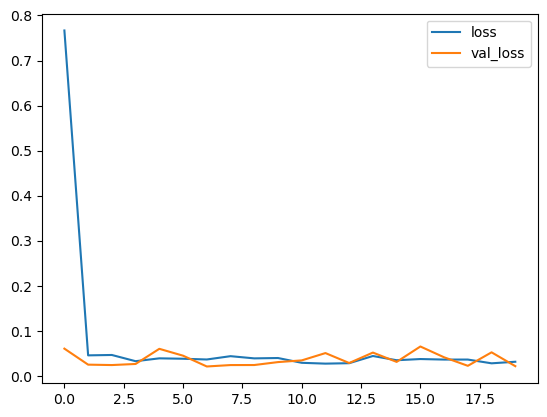

In [17]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

In [20]:
# print(type(forecast_series))
# print(forecast_series.shape)


In [20]:
train_length = len(vol_train)
train_length

4947

In [25]:
window_size = 24
forecast = []
# forecast_series = va['vol'].values 
forecast_series = vol_test['vol'].values

In [26]:
import numpy as np

In [27]:
for time in range(len(forecast_series) - window_size):
    # Slice a window of shape (720,)
    input_data = forecast_series[time:time + window_size]  # Shape: (720,)

    # Add batch and feature dimensions to make it (1, 720, 1)
    input_data = np.expand_dims(input_data, axis=-1)  # Shape: (720, 1)
    input_data = np.expand_dims(input_data, axis=0)  # Shape: (1, 720, 1)

    # Predict and append the result
    forecast.append(dnn_model.predict(input_data))

1/1 [==============================] - 0s 22ms/step


In [28]:
results = np.array(forecast).squeeze()

In [29]:
# forecast_series = va[train_length - window_size:]

In [30]:
# len(results) = len(forecast_series) - window_size


In [34]:
forecast_series = vol_test['vol'].values

# Prepare sliding windows
num_windows = len(forecast_series) - window_size
all_windows = np.array([forecast_series[i:i + window_size] for i in range(num_windows)])
all_windows = np.expand_dims(all_windows, axis=-1)  # Shape: (num_windows, 720, 1)

# Perform batch predictions
# results = dnn_model.predict(all_windows).squeeze()  # Shape: (num_windows,)

# Truncate vol_test to align with predictions
# vol_test_truncated = vol_test.iloc[window_size:] 
vol_test_truncated = vol_test.iloc[window_size:].copy()  # Use .copy() to avoid a view# Drop the first window_size rows
vol_test_truncated.loc[:, 'Pred'] = results
# vol_test_truncated['Pred'] = results

# Display or analyze the results
print(vol_test_truncated.head())

                     box_id  temperature    vol  battery_soc        soc  \
event_time                                                                
2024-11-06 00:25:00  7832.0        34.54  3.756        33.02  70.279131   
2024-11-06 00:26:00  7832.0        34.60  3.753        32.89  69.976818   
2024-11-06 00:27:00  7832.0        34.65  3.756        32.75  70.279131   
2024-11-06 00:28:00  7832.0        34.65  3.756        32.75  70.279131   
2024-11-06 00:29:00  7832.0        34.72  3.756        32.66  70.279131   

                         soc_2      Pred  
event_time                                
2024-11-06 00:25:00  66.903832  3.775011  
2024-11-06 00:26:00  66.613438  3.774501  
2024-11-06 00:27:00  66.903832  3.773500  
2024-11-06 00:28:00  66.903832  3.773242  
2024-11-06 00:29:00  66.903832  3.772509  


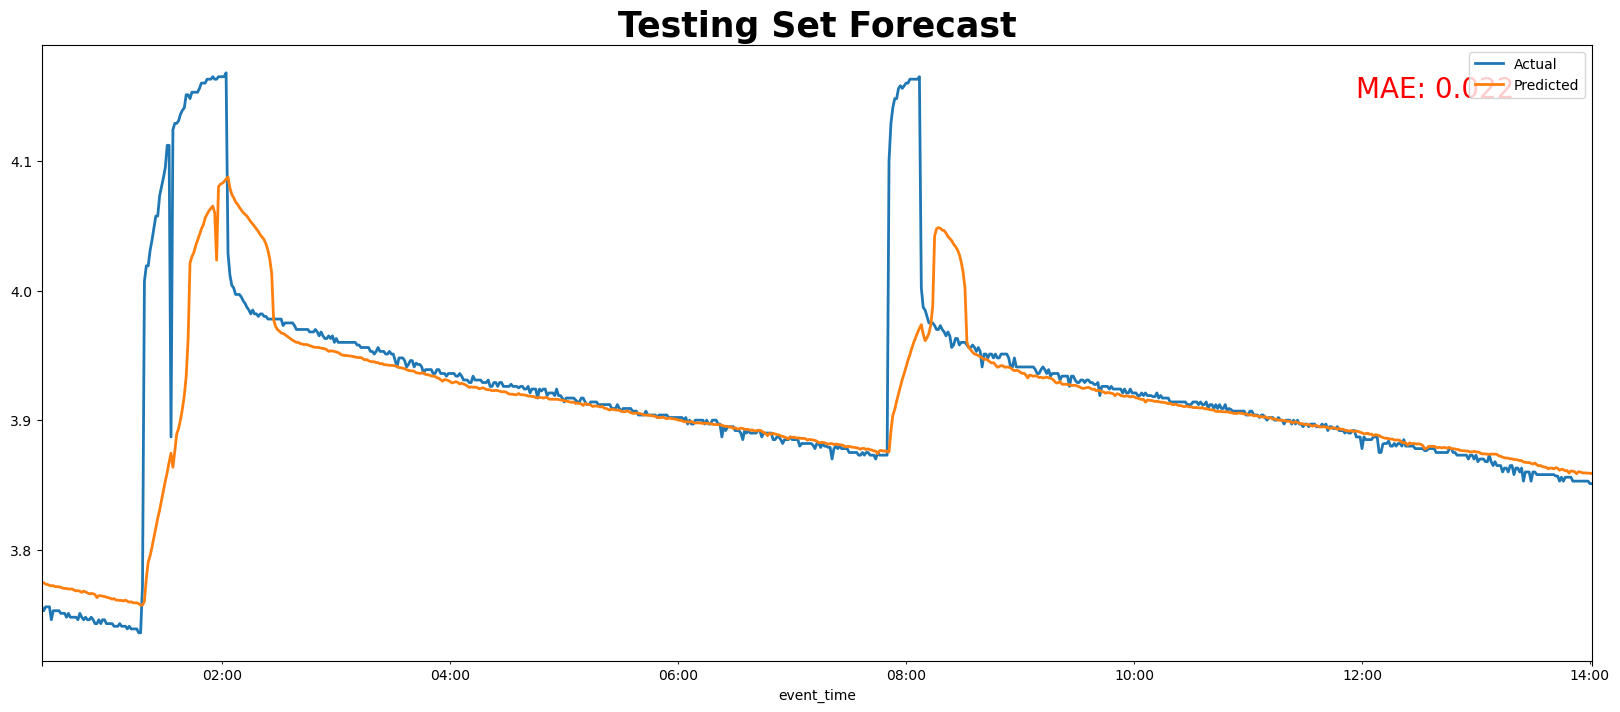

In [35]:
from sklearn.metrics import mean_absolute_error

# Compute MAE using the truncated DataFrame
mae = round(mean_absolute_error(vol_test_truncated['vol'], vol_test_truncated['Pred']), 3)

# Plot actual vs. predicted values
plt.figure(figsize=(20, 8))

vol_test_truncated['vol'].plot(label='Actual', linewidth=2)
vol_test_truncated['Pred'].plot(label='Predicted', linewidth=2)

# Add MAE as text annotation
plt.text(0.95, 0.95, f'MAE: {mae}', fontsize=20, color='red', transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top')

# Customize plot
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()


1/1 [==============================] - 0s 19ms/step


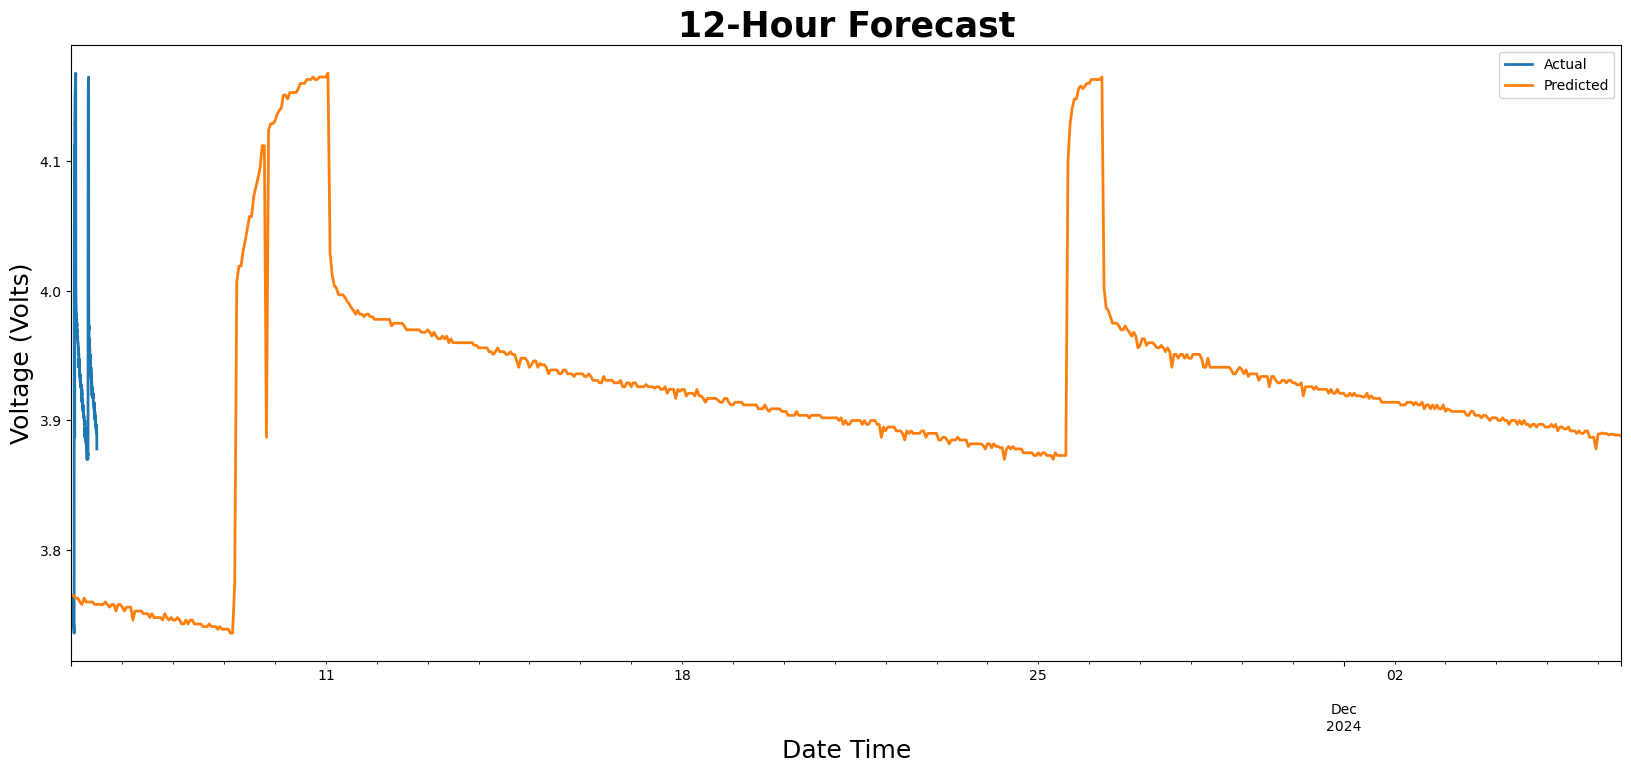

In [40]:
# Set the window size for prediction (24 hours for each window)
window_size = 24

# Initialize df_forecast using the last 24 known values from vol_test, or from an appropriate start point
# For this example, we start from '2024-11-06 00:00:00' to '2024-11-06 12:00:00'
df_forecast = vol_test.loc['2024-11-06 00:00:00':'2024-11-06 12:00:00', ['vol']].copy()

# Reset the index to simplify processing
df_forecast.reset_index(drop=True, inplace=True)

# Check if 'Pred' column exists and if not, initialize it
if 'Pred' not in vol_test.columns:
    vol_test['Pred'] = None  # Initialize the 'Pred' column with None or NaN

# Now generate predictions for the next 12 hours (12 hours ahead)
for time in range(12):  # Forecast for 12 hours ahead
    # Use the last `window_size` values (24 hours) for prediction input
    input_data = np.expand_dims(df_forecast['vol'].iloc[-window_size:].values, axis=-1)  # Shape: (24, 1)
    input_data = np.expand_dims(input_data, axis=0)  # Shape: (1, 24, 1)
    
    # Predict the next value
    pred = dnn_model.predict(input_data)[0][0]
    
    # Append the prediction to df_forecast
    df_forecast = pd.concat([df_forecast, pd.DataFrame({'vol': [pred]})], ignore_index=True)

# Create a new date range for the predicted values (24 + 12 hours)
start_date = pd.to_datetime('2024-11-06 00:00:00')  # Start from '2024-11-06 00:00:00'
date_index = pd.date_range(start=start_date, periods=len(df_forecast), freq='H')  # 24 + 12 time steps

# Assign the new date index to df_forecast
df_forecast.set_index(date_index, inplace=True)

# Now, we will assign the predictions (12 hours ahead) to the 'Pred' column in vol_test
# We need to match the length of the predictions with the time period we are forecasting
vol_test.loc['2024-11-06 00:00:00':'2024-11-06 12:00:00', 'Pred'] = df_forecast['vol'].values[:len(vol_test.loc['2024-11-06 00:00:00':'2024-11-06 12:00:00'])]

# Now you have the forecasted values, let's plot them
plt.figure(figsize=(20, 8))

# Plot the actual values (assuming 'vol' is the actual voltage data in vol_test)
vol_test.loc['2024-11-06 00:00:00':'2024-11-06 12:00:00', 'vol'].plot(label='Actual', linewidth=2)

# Plot the predicted values from df_forecast
df_forecast['vol'].plot(label='Predicted', linewidth=2)

# Add title and labels
plt.title('12-Hour Forecast', weight='bold', fontsize=25)
plt.xlabel('Date Time', fontsize=18)
plt.ylabel('Voltage (Volts)', fontsize=18)
plt.legend()
plt.show()
